## 2 - Качественный модуль

### 2.1 - Библиотеки

In [1]:
import pandas as pd
import numpy as np

import yaml
import io

from _utils.woe_binning import woe
from _utils.model_test_functions import *
import _utils.feature_selection_tests as fst
import _utils.woe_analysis as wa 


import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report,
                             roc_auc_score,
                             precision_recall_curve)

from _utils.ExcelExporter import ExcelExporter
from _utils.Style import Style

import warnings
warnings.filterwarnings("ignore")

### 2.2 - Данные

In [2]:
with open('../CONFIGS.yaml', 'r', encoding='utf-8') as file:
    CONFIG = yaml.safe_load(file)

In [3]:
PATHS = CONFIG['data_paths']

In [4]:
filepath = {
      'qualitative_df' : PATHS['module_qualitative']['processed_data']
    , 'rating_weights' : PATHS['ratings']['weights']
    , 'predictions'    : PATHS['module_qualitative']['predictions']
    , 'woe_category_map' : PATHS['module_qualitative']['woe_category_map']
    , 'config' : PATHS['other']['this_config']
    , 'excel': PATHS['module_qualitative']['excel']
    , 'business_meaning' : PATHS['module_qualitative']['mapping_original']
}

weight_col = 'W_norm'
target_col = 'target'
id_cols = ['client_id', 'rating_id']

In [5]:
# Загрузка маппинга для качественных переменных
with open(filepath['business_meaning'], 'r', encoding='utf-8') as stream:
    df_meaning = yaml.safe_load(stream)

df_meaning = pd.DataFrame([
    {'feature': feature, 'category_code': code, 'category_meaning': meaning}
    for feature, categories in df_meaning.items()
    for meaning, code in categories.items()
])

In [6]:
df_main    = pd.read_parquet(filepath['qualitative_df'])
df_weights = pd.read_parquet(filepath['rating_weights'])

df_meaning

print('Размерность до merge')
print(f'df_woe: {df_main.shape[0]},\ndf_weights: {df_weights.shape[0]}')

df_main = pd.merge(df_main,
                   df_weights[['client_id', 'rating_id', weight_col, 'target']],
                   how='inner',
                   on=['client_id', 'rating_id'])
print('Размерность после merge')
print(f'df_main: {df_main.shape[0]}')

Размерность до merge
df_woe: 4984,
df_weights: 4984
Размерность после merge
df_main: 4984


In [7]:
qualitative_cols = [col for col in df_main.columns if 'kfx' in col]

### 2.3 - Препроцессинг

#### 2.3.1 - WOE-преобразование

In [8]:
woe_results = []
feature_woe_info = {}
failed_columns = []

for col in qualitative_cols:
    try:
        woe_result = woe(df_main, col, target_col, with_IV=False, weight_column=weight_col)
        woe_result = woe_result.sort_values('woe')
        feature_woe_info[col] = woe_result  # Use column name as key instead of index
        print(f'✅ WoE calculated for {col}')
    except Exception as e:
        failed_columns.append(col)
        print(f'❌ Couldn\'t calculate WoE for {col}: {e}')

# Optional: Print summary
print(f"\n📊 Processed: {len(feature_woe_info)}/{len(qualitative_cols)} columns")

✅ WoE calculated for kfx0
✅ WoE calculated for kfx3
✅ WoE calculated for kfx4
✅ WoE calculated for kfx5
✅ WoE calculated for kfx6
✅ WoE calculated for kfx7
✅ WoE calculated for kfx8
✅ WoE calculated for kfx9
✅ WoE calculated for kfx10
✅ WoE calculated for kfx13
✅ WoE calculated for kfx14
✅ WoE calculated for kfx15
✅ WoE calculated for kfx18
✅ WoE calculated for kfx19
✅ WoE calculated for kfx20
✅ WoE calculated for kfx23

📊 Processed: 16/16 columns


#### 2.3.2 - Замена исходных значений на WoE-значения

In [9]:
df_woe = df_main.copy(deep=True)

# Создаем словарь замен для всех колонок сразу
for col in qualitative_cols:
    if col in feature_woe_info:
        replace_dict = dict(zip(feature_woe_info[col]['category'], feature_woe_info[col]['woe']))
        df_woe[col] = df_woe[col].map(replace_dict).fillna(df_woe[col])  # fillna сохраняет незамененные значения

### 2.4 - Статистические тесты

#### 2.4.1 - Проверка на монотонность

In [10]:
feature_monotonicity_info = { col :  wa.check_woe_monotonicity(feature_woe_info[col]) for col in qualitative_cols }

In [11]:
monotonic_features = [ col for col in qualitative_cols 
                            if wa.check_woe_monotonicity(feature_woe_info[col])['is_monotonic']==True
                             and wa.check_woe_monotonicity(feature_woe_info[col])['follows_business_logic']==True]

non_monotonic_features = list(set(qualitative_cols) - set(monotonic_features))
print(f'Монотонных признаков {len(monotonic_features)} из {len(qualitative_cols)}')

Монотонных признаков 6 из 16


In [12]:
old_to_new_categories_map = {}

In [13]:
for mon_f in monotonic_features:
    print(mon_f)
    display(feature_woe_info[mon_f])
    print('')

kfx0


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
3,kfx0,4,39.876472,0.800090,30.521456,0.658396,9.355015,3.566409,23.459988,-168.950776
1,kfx0,3,1561.443267,31.329119,1426.969560,30.296460,134.473707,48.845322,8.612142,-47.762773
0,kfx0,2,3340.010598,67.014659,3209.510487,68.128916,130.500110,47.407326,3.907177,36.262496
2,kfx0,1,42.669663,0.856133,42.669663,0.916228,0.000000,0.180944,0.000000,162.207884



kfx3


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
2,kfx3,3,66.434819,1.332962,61.737704,1.321066,4.697116,1.884181,7.070262,-35.505411
1,kfx3,2,993.197813,19.927725,926.685004,19.680563,66.512809,24.295070,6.696834,-21.064197
0,kfx3,1,3924.367368,78.739313,3721.248460,78.998371,203.118908,73.820748,5.175838,6.778739



kfx4


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
2,kfx4,3,27.172284,0.545190,19.980124,0.434714,7.192160,2.788744,26.468737,-185.865814
1,kfx4,2,1629.644165,32.697515,1515.602834,32.181018,114.041332,41.526236,6.997928,-25.494865
0,kfx4,1,3327.183550,66.757294,3174.088210,67.384268,153.095340,55.685020,4.601349,19.070041



kfx9


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
2,kfx9,3,19.649622,0.394254,16.578413,0.362509,3.071210,1.294720,15.629867,-127.300050
0,kfx9,2,2564.947150,51.463627,2407.569860,51.114039,157.377290,57.237414,6.135693,-11.314858
1,kfx9,1,2399.403228,48.142119,2285.522895,48.523452,113.880333,41.467867,4.746194,15.712840



kfx18


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
1,kfx18,3,448.405128,8.996893,421.360070,8.954463,27.045058,9.986287,6.031389,-10.906077
0,kfx18,2,4439.782064,89.080700,4196.371948,89.083410,243.410116,88.428071,5.482479,0.738366
2,kfx18,1,95.812808,1.922408,91.939150,1.962127,3.873658,1.585642,4.042944,21.303947



kfx23


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
1,kfx23,2,658.100695,13.204268,609.811204,12.955929,48.289491,17.720444,7.337706,-31.316548
0,kfx23,1,4325.899305,86.795732,4099.859963,87.044071,226.039341,82.279556,5.225257,5.629188


In [14]:
# Маленькие бины объединяем со смежными большими, чтобы было меньше вероятности, что монотонность сломается на новых данных
monotonic_fixes ={
      'kfx0'  : [ [4,3], [2,1] ]
    , 'kfx3'  : [[3,2]]
    , 'kfx4'  : [[3,2]]
    , 'kfx9'  : [[3,2]]
    , 'kfx18' : [[1,2]]
}

old_to_new_categories_map = wa.update_old_to_new_category_mapping(old_to_new_categories_map, monotonic_fixes)

In [15]:
for fix_col, all_combiniations in monotonic_fixes.items():
    for combo in all_combiniations:
        curr_woe_stats = feature_woe_info[fix_col]
        curr_mono_info = feature_monotonicity_info[fix_col]
        df_woe, feature_woe_info[fix_col], feature_monotonicity_info[fix_col] = wa.merge_categories(data=df_woe
                                                                                           , col=fix_col
                                                                                           , categories=combo
                                                                                           , feature_woe_stats=curr_woe_stats
                                                                                           , target_col=target_col
                                                                                           , weight_col=weight_col
                                                                                           , feature_monotonicity_check=curr_mono_info)

In [16]:
for non_mon_f in non_monotonic_features:
    print(non_mon_f)
    display(feature_woe_info[non_mon_f])
    print('')

kfx19


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
3,kfx19,4,40.876458,0.820154,33.202169,0.715215,7.674289,2.952832,18.774350,-141.793625
0,kfx19,3,2416.186640,48.478865,2269.782393,48.179116,146.404246,53.066816,6.059310,-9.662615
2,kfx19,2,996.397784,19.991930,946.299350,20.092635,50.098434,18.277877,5.027955,9.466189
1,kfx19,1,1513.513618,30.367448,1443.361755,30.641114,70.151863,25.521858,4.635033,18.280743
4,kfx19,5,17.025501,0.341603,17.025501,0.371920,0.000000,0.180617,0.000000,72.229955



kfx14


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
1,kfx14,3,619.806289,12.435921,570.438901,12.117546,49.367387,18.046393,7.964970,-39.829139
3,kfx14,4,65.598248,1.316177,61.107685,1.307555,4.490563,1.806023,6.845553,-32.296841
0,kfx14,2,4112.345912,82.510953,3895.990236,82.698688,216.355676,78.477397,5.261125,5.239308
2,kfx14,1,186.249552,3.736949,182.134346,3.876212,4.115206,1.670186,2.209512,84.192315



kfx20


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
4,kfx20,9,156.362095,3.137281,99.936435,2.130522,56.425660,20.415988,36.086534,-225.995148
8,kfx20,8,14.878494,0.298525,13.074806,0.287957,1.803688,0.826202,12.122788,-105.402621
6,kfx20,6,88.303291,1.771735,77.360214,1.651620,10.943077,4.103979,12.392604,-91.020016
7,kfx20,7,36.387149,0.730079,32.477053,0.699530,3.910096,1.581650,10.745817,-81.581491
3,kfx20,5,425.109655,8.529487,386.035584,8.199439,39.074071,14.192962,9.191528,-54.868050
2,kfx20,4,521.082487,10.455106,475.772893,10.103004,45.309593,16.429288,8.695282,-48.623284
5,kfx20,3,193.715368,3.886745,183.989595,3.913511,9.725773,3.667401,5.020651,6.495149
1,kfx20,2,612.057711,12.280452,582.172855,12.360028,29.884856,10.897315,4.882686,12.595126
0,kfx20,1,2936.103750,58.910589,2858.851733,60.654389,77.252017,27.885214,2.631107,77.709541



kfx7


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
0,kfx7,1,1952.424609,39.173849,1821.776167,38.675793,130.648442,47.461006,6.691600,-20.469455
3,kfx7,4,279.699759,5.611953,263.379547,5.600551,16.320211,6.087027,5.834904,-8.329482
2,kfx7,3,1136.837033,22.809732,1079.979018,22.931970,56.858015,20.757159,5.001422,9.964080
1,kfx7,2,1615.038599,32.404466,1544.536435,32.791686,70.502164,25.694808,4.365355,24.388606



kfx15


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
1,kfx15,4,1119.122319,22.454300,1051.150718,22.317753,67.971601,24.734274,6.073653,-10.280742
0,kfx15,5,2998.352667,60.159564,2819.302778,59.840839,179.049889,64.859534,5.971609,-8.053555
3,kfx15,2,256.339775,5.143254,247.156671,5.255681,9.183104,3.497867,3.582395,40.715622
2,kfx15,3,539.234644,10.819315,521.110406,11.069428,18.124238,6.727709,3.361104,49.795244
4,kfx15,1,70.950595,1.423567,70.950595,1.516299,0.000000,0.180617,0.000000,212.764875



kfx5


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
2,kfx5,4,529.689289,10.627795,486.355635,10.332971,43.333654,15.862859,8.180957,-42.864060
1,kfx5,3,1286.601504,25.814637,1203.463896,25.552800,83.137608,30.267420,6.461799,-16.932499
3,kfx5,1,223.229195,4.478916,212.156515,4.513399,11.072680,4.188010,4.960229,7.482475
0,kfx5,2,2944.480013,59.078652,2807.695122,59.600830,136.784891,49.681711,4.645468,18.203263



kfx10


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
2,kfx10,4,602.385631,12.086389,539.192644,11.454378,63.192988,23.049708,10.490454,-69.928103
1,kfx10,3,1782.030192,35.755020,1650.714697,35.045202,131.315495,47.702404,7.368870,-30.834306
3,kfx10,1,177.151897,3.554412,169.070207,3.598940,8.081691,3.105608,4.562012,14.742973
0,kfx10,2,2422.432279,48.604179,2350.693621,49.901479,71.738658,26.142281,2.961431,64.649670



kfx6


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
3,kfx6,1,146.613823,2.941690,132.936388,2.832039,13.677436,5.130639,9.328885,-59.423315
1,kfx6,4,1281.703149,25.716355,1176.456518,24.979598,105.246632,38.268403,8.211467,-42.656516
2,kfx6,3,1077.490657,21.618994,1016.415265,21.582900,61.075392,22.283376,5.668299,-3.193960
0,kfx6,2,2478.192370,49.722961,2383.862997,50.605463,94.329373,34.317582,3.806378,38.840172



kfx8


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
3,kfx8,4,275.687356,5.531448,244.241117,5.193808,31.446239,11.540069,11.406486,-79.835815
4,kfx8,3,272.803862,5.473593,247.470996,5.262351,25.332865,9.331711,9.286109,-57.284041
1,kfx8,5,1985.317970,39.833828,1879.599861,39.898802,105.718109,38.369598,5.324996,3.908089
0,kfx8,1,2065.490756,41.442431,1967.505251,41.764299,97.985505,35.576318,4.743933,16.036170
2,kfx8,2,384.700057,7.718701,370.853943,7.880740,13.846114,5.182305,3.599197,41.917186



kfx13


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
1,kfx13,2.0,984.120776,19.745601,924.706999,19.638577,59.413776,21.721361,6.037244,-10.080028
0,kfx13,3.0,3834.704839,76.940306,3627.065216,76.999223,207.639622,75.459705,5.414748,2.019654
2,kfx13,1.0,165.174386,3.314093,157.898952,3.362199,7.275434,2.818934,4.404698,17.623633


In [17]:
nonmonotonic_fixes ={
      'kfx15' : [ [4,5], [2,3,1] ]
    , 'kfx8'  : [ [4,3,5], [1,2] ]
    , 'kfx5'  : [[2,1]]
    , 'kfx10' : [[1,2]]
    , 'kfx14' : [[3,4]]
    , 'kfx20' : [[8, 6, 7], [5,4], [3, 2]]
    , 'kfx13' : [[2,3]]
}

old_to_new_categories_map = wa.update_old_to_new_category_mapping(old_to_new_categories_map, nonmonotonic_fixes)

In [18]:
for fix_col, all_combiniations in nonmonotonic_fixes.items():
    for combo in all_combiniations:
        curr_woe_stats = feature_woe_info[fix_col]
        curr_mono_info = feature_monotonicity_info[fix_col]
        df_woe, feature_woe_info[fix_col], feature_monotonicity_info[fix_col] = wa.merge_categories(data=df_woe
                                                                                           , col=fix_col
                                                                                           , categories=combo
                                                                                           , feature_woe_stats=curr_woe_stats
                                                                                           , target_col=target_col
                                                                                           , weight_col=weight_col
                                                                                           , feature_monotonicity_check=curr_mono_info)

In [19]:
for non_mon_f in non_monotonic_features:
    print(non_mon_f)
    display(feature_woe_info[non_mon_f])
    print('')

kfx19


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
3,kfx19,4,40.876458,0.820154,33.202169,0.715215,7.674289,2.952832,18.774350,-141.793625
0,kfx19,3,2416.186640,48.478865,2269.782393,48.179116,146.404246,53.066816,6.059310,-9.662615
2,kfx19,2,996.397784,19.991930,946.299350,20.092635,50.098434,18.277877,5.027955,9.466189
1,kfx19,1,1513.513618,30.367448,1443.361755,30.641114,70.151863,25.521858,4.635033,18.280743
4,kfx19,5,17.025501,0.341603,17.025501,0.371920,0.000000,0.180617,0.000000,72.229955



kfx14


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
1,kfx14,3,685.404536,13.752097,631.546586,13.415912,53.857950,19.707131,7.857834,-38.453909
0,kfx14,2,4112.345912,82.510953,3895.990236,82.707465,216.355676,78.619655,5.261125,5.068813
2,kfx14,1,186.249552,3.736949,182.134346,3.876623,4.115206,1.673214,2.209512,84.021819



kfx20


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
3,kfx20,9,156.362095,3.137281,99.936435,2.131426,56.425660,20.563487,36.086534,-226.672585
4,kfx20,6,139.568934,2.800340,122.912072,2.619007,16.656862,6.197643,11.934505,-86.137395
1,kfx20,4,946.192141,18.984594,861.808477,18.299600,84.383664,30.662870,8.918238,-51.617326
2,kfx20,2,805.773079,16.167197,766.162451,16.269835,39.610629,14.489325,4.915854,11.590059
0,kfx20,1,2936.103750,58.910589,2858.851733,60.680133,77.252017,28.086676,2.631107,77.032105



kfx7


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
0,kfx7,1,1952.424609,39.173849,1821.776167,38.675793,130.648442,47.461006,6.691600,-20.469455
3,kfx7,4,279.699759,5.611953,263.379547,5.600551,16.320211,6.087027,5.834904,-8.329482
2,kfx7,3,1136.837033,22.809732,1079.979018,22.931970,56.858015,20.757159,5.001422,9.964080
1,kfx7,2,1615.038599,32.404466,1544.536435,32.791686,70.502164,25.694808,4.365355,24.388606



kfx15


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
0,kfx15,4,4117.474986,82.613864,3870.453496,82.174139,247.021490,89.900316,5.999344,-8.986081
1,kfx15,1,866.525014,17.386136,839.217672,17.825861,27.307342,10.099684,3.151362,56.814611



kfx5


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
2,kfx5,4,529.689289,10.627795,486.355635,10.334068,43.333654,15.891614,8.180957,-43.034555
1,kfx5,3,1286.601504,25.814637,1203.463896,25.555512,83.137608,30.322286,6.461799,-17.102994
0,kfx5,1,3167.709208,63.557568,3019.851637,64.110420,147.857571,53.786100,4.667650,17.559185



kfx10


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
2,kfx10,4,602.385631,12.086389,539.192644,11.455594,63.192988,23.091490,10.490454,-70.098599
1,kfx10,3,1782.030192,35.755020,1650.714697,35.048922,131.315495,47.788875,7.368870,-31.004802
0,kfx10,1,2599.584177,52.158591,2519.763827,53.495484,79.820349,29.119635,3.070505,60.818455



kfx6


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
3,kfx6,1,146.613823,2.941690,132.936388,2.832039,13.677436,5.130639,9.328885,-59.423315
1,kfx6,4,1281.703149,25.716355,1176.456518,24.979598,105.246632,38.268403,8.211467,-42.656516
2,kfx6,3,1077.490657,21.618994,1016.415265,21.582900,61.075392,22.283376,5.668299,-3.193960
0,kfx6,2,2478.192370,49.722961,2383.862997,50.605463,94.329373,34.317582,3.806378,38.840172



kfx8


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
0,kfx8,3,2533.809187,50.838868,2371.311974,50.349767,162.497214,59.200924,6.413159,-16.194316
1,kfx8,1,2450.190813,49.161132,2338.359194,49.650233,111.831619,40.799076,4.564200,19.634365



kfx13


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
0,kfx13,2.0,4818.825614,96.685907,4551.772216,96.637444,267.053399,97.175946,5.541877,-0.555693
1,kfx13,1.0,165.174386,3.314093,157.898952,3.362556,7.275434,2.824054,4.404698,17.452810


In [20]:
monotonic_features += [feature for feature in nonmonotonic_fixes.keys() if feature_monotonicity_info[feature]['follows_business_logic']]
non_monotonic_features = [col for col in non_monotonic_features if col not in monotonic_features]

In [21]:
for non_mon_f in nonmonotonic_fixes.keys():
    print(non_mon_f)
    print('Бизнес логика соблюдена?',feature_monotonicity_info[non_mon_f]['follows_business_logic'])
    display(feature_woe_info[non_mon_f])
    print('')

kfx15
Бизнес логика соблюдена? True


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
0,kfx15,4,4117.474986,82.613864,3870.453496,82.174139,247.021490,89.900316,5.999344,-8.986081
1,kfx15,1,866.525014,17.386136,839.217672,17.825861,27.307342,10.099684,3.151362,56.814611



kfx8
Бизнес логика соблюдена? True


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
0,kfx8,3,2533.809187,50.838868,2371.311974,50.349767,162.497214,59.200924,6.413159,-16.194316
1,kfx8,1,2450.190813,49.161132,2338.359194,49.650233,111.831619,40.799076,4.564200,19.634365



kfx5
Бизнес логика соблюдена? True


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
2,kfx5,4,529.689289,10.627795,486.355635,10.334068,43.333654,15.891614,8.180957,-43.034555
1,kfx5,3,1286.601504,25.814637,1203.463896,25.555512,83.137608,30.322286,6.461799,-17.102994
0,kfx5,1,3167.709208,63.557568,3019.851637,64.110420,147.857571,53.786100,4.667650,17.559185



kfx10
Бизнес логика соблюдена? True


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
2,kfx10,4,602.385631,12.086389,539.192644,11.455594,63.192988,23.091490,10.490454,-70.098599
1,kfx10,3,1782.030192,35.755020,1650.714697,35.048922,131.315495,47.788875,7.368870,-31.004802
0,kfx10,1,2599.584177,52.158591,2519.763827,53.495484,79.820349,29.119635,3.070505,60.818455



kfx14
Бизнес логика соблюдена? True


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
1,kfx14,3,685.404536,13.752097,631.546586,13.415912,53.857950,19.707131,7.857834,-38.453909
0,kfx14,2,4112.345912,82.510953,3895.990236,82.707465,216.355676,78.619655,5.261125,5.068813
2,kfx14,1,186.249552,3.736949,182.134346,3.876623,4.115206,1.673214,2.209512,84.021819



kfx20
Бизнес логика соблюдена? True


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
3,kfx20,9,156.362095,3.137281,99.936435,2.131426,56.425660,20.563487,36.086534,-226.672585
4,kfx20,6,139.568934,2.800340,122.912072,2.619007,16.656862,6.197643,11.934505,-86.137395
1,kfx20,4,946.192141,18.984594,861.808477,18.299600,84.383664,30.662870,8.918238,-51.617326
2,kfx20,2,805.773079,16.167197,766.162451,16.269835,39.610629,14.489325,4.915854,11.590059
0,kfx20,1,2936.103750,58.910589,2858.851733,60.680133,77.252017,28.086676,2.631107,77.032105



kfx13
Бизнес логика соблюдена? True


,col_name,category,count_obs,general_distribution,goods,distribution_of_good,bads,distribution_of_bad,share_of_bad,woe
0,kfx13,2.0,4818.825614,96.685907,4551.772216,96.637444,267.053399,97.175946,5.541877,-0.555693
1,kfx13,1.0,165.174386,3.314093,157.898952,3.362556,7.275434,2.824054,4.404698,17.452810


Собрать маппинги старые в новые в одном месте

In [22]:
dd = {}
for f, mapp in old_to_new_categories_map.items():
    dd[f] = {}
    for mapped_from, mapped_to in mapp.items():
        if mapped_to in dd[f]:  # Check if key exists in dd[f], not in mapp.keys()
            # Add mapped_from to existing list
            dd[f][mapped_to].append(mapped_from)
        else:
            # Initialize with both mapped_to and mapped_from
            dd[f][mapped_to] = [mapped_to, mapped_from]
    
    # Remove duplicates from all lists
    for key in dd[f]:
        dd[f][key] = list(set(dd[f][key]))

for f in qualitative_cols:
    if f in dd.keys():
        feature_woe_info[f]['all_old_categories'] = feature_woe_info[f]['category'].apply(
            lambda x: dd[f].get(x, [x])  
        )
    else:
        feature_woe_info[f]['all_old_categories'] = feature_woe_info[f]['category'].apply(lambda x: [x])

In [23]:
monotonic_features += [feature for feature in nonmonotonic_fixes.keys() if feature_monotonicity_info[feature]['follows_business_logic']]
non_monotonic_features = [col for col in non_monotonic_features if col not in monotonic_features]

In [24]:
non_monotonic_features

['kfx19', 'kfx7', 'kfx6']

#### 2.4.5 - Корреляционный анализ

In [25]:
id_columns = ['rating_id', 'target',  'client_id', weight_col]

Cramer's V

In [26]:
redundancy = fst.analyze_feature_redundancy(df=df_woe, columns=qualitative_cols, threshold=0.7, weights_col=weight_col)
print("\n⚠️ Потенциально взаимозаменяемые признаки:")
for main_feat, info in redundancy.items():
    print(f"\n  {main_feat}:")
    for corr_feat in info['correlated_with']:
        print(f"    - {corr_feat['feature']} (V={corr_feat['correlation']:.3f})")



⚠️ Потенциально взаимозаменяемые признаки:

  kfx8:
    - kfx9 (V=0.721)

  kfx9:
    - kfx8 (V=0.721)


Spearman

In [27]:
spearman_corr = pd.DataFrame(df_woe[qualitative_cols].corr(method='spearman').unstack(), 
                             columns=['value'])
spearman_corr = spearman_corr[abs(spearman_corr.value) > 0.65].reset_index()
spearman_corr.columns = ['col1', 'col2', 'value']
spearman_corr = spearman_corr.query('col1 != col2').set_index(['col1']).set_axis(['correlated_with', 'corr_strength'], axis=1)
spearman_corr_info = spearman_corr.T.to_dict()
spearman_corr_info


{'kfx8': {'correlated_with': 'kfx9', 'corr_strength': 0.7238728417791983},
 'kfx9': {'correlated_with': 'kfx8', 'corr_strength': 0.7238728417791983}}

#### 2.4.6 - Gini

In [28]:
df_gini_results = fst.calculate_features_gini(df_woe
                                            , target_col
                                            , qualitative_cols
                                            , weight_col)\
                    .sort_values(['Gini'], ascending=False)\
                    .drop_duplicates()

feature_gini_info = df_gini_results['Gini'].to_dict()

feature_gini_info

{'kfx20': 0.44987383536256953,
 'kfx10': 0.2396882143144914,
 'kfx0': 0.23001827796932184,
 'kfx6': 0.1460719329270619,
 'kfx8': 0.10801304478738616,
 'kfx4': 0.10596302846019778,
 'kfx7': 0.10171287048934907,
 'kfx15': 0.09876719125710864,
 'kfx19': 0.07427980135960954,
 'kfx9': 0.07420177012166929,
 'kfx14': 0.06831041165718843,
 'kfx3': 0.055137551261010165,
 'kfx5': 0.04142949835243814,
 'kfx23': 0.03836507593202798,
 'kfx18': 0.02882066810006667,
 'kfx13': 0.007790401309567763}

#### 2.4.7 - VIF

In [29]:
feature_vif_info = fst.calculate_vif(df=df_woe,
                    target=target_col,
                    features=qualitative_cols)
print(feature_vif_info)

{'kfx0': 1.1246208418328911, 'kfx3': 1.2540239574034158, 'kfx4': 1.2407378245961411, 'kfx5': 1.5330634934460114, 'kfx6': 1.5478047768771181, 'kfx7': 1.0874428132268266, 'kfx8': 2.140152355351732, 'kfx9': 2.1819491134898934, 'kfx10': 1.0745585955848036, 'kfx13': 1.1149244970385626, 'kfx14': 1.2113460471113124, 'kfx15': 1.184080992314358, 'kfx18': 1.1361602805183766, 'kfx19': 1.0523003721855844, 'kfx20': 1.1281485649961078, 'kfx23': 1.0846273148714274}


#### 2.4.8 - Тест Вальда

In [30]:
feature_wald_test_info = {col : fst.quick_wald_test(  df=df_woe
                                                    , feature=col
                                                    , target=target_col
                                                    , weights_col=weight_col) for col in qualitative_cols}
feature_wald_test_info

{'kfx0': {'coefficient': np.float64(-0.010725078275343735),
  'std_error': np.float64(0.0014556624386368048),
  'wald_statistic': np.float64(54.284968411178156),
  'p_value': np.float64(1.7342337065082488e-13),
  'is_significant': np.True_,
  'weighted': True,
  'effective_sample_size': np.float64(4984.0)},
 'kfx3': {'coefficient': np.float64(-0.010722037649821303),
  'std_error': np.float64(0.0052261300807356975),
  'wald_statistic': np.float64(4.2091482781110665),
  'p_value': np.float64(0.040206520346925415),
  'is_significant': np.True_,
  'weighted': True,
  'effective_sample_size': np.float64(4984.0)},
 'kfx4': {'coefficient': np.float64(-0.009153035130978562),
  'std_error': np.float64(0.002666243233524195),
  'wald_statistic': np.float64(11.785030910181021),
  'p_value': np.float64(0.0005970890090151596),
  'is_significant': np.True_,
  'weighted': True,
  'effective_sample_size': np.float64(4984.0)},
 'kfx5': {'coefficient': np.float64(-0.003995279083167169),
  'std_error': np

### 2.5 - Отбор признаков

In [31]:
# Джойним df_woe с датами
df_woe_with_dates = df_woe.merge(df_weights[['rating_id', 'rating_assignment_date']], on=['rating_id'])

# НАСТРОЙКИ:
date_column = 'rating_assignment_date'
baseline_year = '2023'  
time_period = 'year'  # 'quarter', 'year', или 'month'

# Собираем все результаты в один датафрейм
feature_analysis_results = []

# Параметры фильтрации
vif_upper_bound = 5
cramer_lower_bound = 0.01
cramer_upper_bound = 0.7
gini_lower_bound = 0.05

for feature in qualitative_cols:
    feature_info = {
        'feature': feature,
        'is_monotonic': None,
        'cramers_v_target': None,
        'gini': None,
        'vif': None,
        'wald_p_value': None,
        'wald_significant': None,
        'wald_coefficient': None,
        'spearman_corr': None,
        'max_cramers_with_others': 0,
        'highly_correlated_features': [],
        'redundancy_score': 0,
        'psi_static': None,
        'psi_dynamic_mean': None,
        'psi_dynamic_max': None,
        'psi_periods_unstable': 0
    }
    
    # Cramér's V с целевой переменной
    feature_info['cramers_v_target'] = fst.calculate_cramers_v(df_woe[feature], df_woe[target_col], df_woe[weight_col])

    if feature in feature_monotonicity_info:
        feature_info['is_monotonic'] = feature_monotonicity_info[feature]['follows_business_logic']
    
    # Gini
    if feature in feature_gini_info:
        feature_info['gini'] = feature_gini_info[feature]
    
    # VIF
    if feature in feature_vif_info:
        feature_info['vif'] = feature_vif_info[feature]
    
    # Wald тест
    if feature in feature_wald_test_info and feature_wald_test_info[feature] is not None:
        wald_result = feature_wald_test_info[feature]
        feature_info['wald_p_value'] = wald_result['p_value']
        feature_info['wald_significant'] = wald_result['is_significant']
        feature_info['wald_coefficient'] = abs(wald_result['coefficient'])
    
    # Spearman корреляция
    if feature in spearman_corr_info:
        feature_info['spearman_corr'] = spearman_corr_info[feature]['corr_strength']
    
    # Избыточность
    if feature in redundancy:
        corr_features = redundancy[feature]['correlated_with']
        feature_info['max_cramers_with_others'] = redundancy[feature]['max_correlation']
        feature_info['highly_correlated_features'] = [f"{cf['feature']}({cf['correlation']:.3f})" for cf in corr_features]
        feature_info['redundancy_score'] = len(corr_features)
    
    # PSI расчеты с джойненными данными
    try:
        # Static PSI: базовый год vs остальные годы
        baseline_mask = df_woe_with_dates[date_column].dt.year.astype(str) == baseline_year
        
        if baseline_mask.sum() > 50 and (~baseline_mask).sum() > 50:  # минимум 50 наблюдений
            baseline_woe = df_woe_with_dates[baseline_mask][feature]
            other_years_woe = df_woe_with_dates[~baseline_mask][feature]
            feature_info['psi_static'] = fst.calculate_psi_woe(baseline_woe, other_years_woe)
        
        # Dynamic PSI: между соседними периодами
        if time_period == 'quarter':
            df_woe_with_dates['period'] = df_woe_with_dates[date_column].dt.to_period('Q')
        elif time_period == 'year':
            df_woe_with_dates['period'] = df_woe_with_dates[date_column].dt.to_period('Y')
        else:
            df_woe_with_dates['period'] = df_woe_with_dates[date_column].dt.to_period('M')
        
        periods = sorted(df_woe_with_dates['period'].unique())
        
        if len(periods) > 1:
            period_psi_values = []
            
            for j in range(1, len(periods)):
                prev_period_woe = df_woe_with_dates[df_woe_with_dates['period'] == periods[j-1]][feature]
                curr_period_woe = df_woe_with_dates[df_woe_with_dates['period'] == periods[j]][feature]
                
                if len(prev_period_woe.dropna()) > 20 and len(curr_period_woe.dropna()) > 20:
                    psi_val = fst.calculate_psi_woe(prev_period_woe, curr_period_woe)
                    if not np.isnan(psi_val):
                        period_psi_values.append(psi_val)
            
            if period_psi_values:
                feature_info['psi_dynamic_mean'] = np.mean(period_psi_values)
                feature_info['psi_dynamic_max'] = np.max(period_psi_values)
                feature_info['psi_periods_unstable'] = sum(1 for psi in period_psi_values if psi > 0.2)
    
    except Exception as e:
        print(f"Ошибка PSI для {feature}: {e}")
    
    feature_analysis_results.append(feature_info)

# Создаем датафрейм
df_feature_analysis = pd.DataFrame(feature_analysis_results)

# Добавляем PSI критерии к маске
psi_static_stable = df_feature_analysis['psi_static'].fillna(0) <= 0.2
psi_dynamic_stable = df_feature_analysis['psi_dynamic_mean'].fillna(0) <= 0.15

# Маска для хороших признаков
good_features_mask = (
      (df_feature_analysis['is_monotonic']) 
    & (df_feature_analysis['gini'].fillna(0) >= gini_lower_bound) 
    # (df_feature_analysis['vif'].fillna(1) <= vif_upper_bound) 
    # & (df_feature_analysis['cramers_v_target'].fillna(0) >= cramer_lower_bound) 
    # & (df_feature_analysis['max_cramers_with_others'] <= cramer_upper_bound) 
    # & (df_feature_analysis['wald_significant'].fillna(False)) 
    # & psi_static_stable 
    # & psi_dynamic_stable
)


df_feature_analysis = df_feature_analysis.sort_values(by=['gini', 'vif', 'cramers_v_target', 'max_cramers_with_others']
                                                    , ascending=[False, True, False, True])

good_features_df = df_feature_analysis[good_features_mask].sort_values('gini', ascending=False)
selected_features = good_features_df['feature'].tolist()

print(f"Хороших признаков: {len(good_features_df)} из {len(df_feature_analysis)}")

print("\nTоп-10 отобранных признаков:")
print(good_features_df[['feature', 'cramers_v_target', 'gini', 'vif', 'psi_static', 'psi_dynamic_mean']].head(10))

print("\nПризнаки с нестабильным PSI:")
unstable_psi = df_feature_analysis[
    (df_feature_analysis['psi_static'] > 0.2) | 
    (df_feature_analysis['psi_dynamic_mean'] > 0.15)
][['feature', 'psi_static', 'psi_dynamic_mean', 'psi_periods_unstable']]
print(unstable_psi.head(10))

print("\nPSI интерпретация:")
print("PSI < 0.1: Стабильное распределение")
print("PSI 0.1-0.2: Небольшой сдвиг")
print("PSI > 0.2: Значительный сдвиг, требует внимания")

Хороших признаков: 9 из 16

Tоп-10 отобранных признаков:
   feature  cramers_v_target      gini       vif  psi_static  psi_dynamic_mean
14   kfx20          0.267514  0.449874  1.128149    0.059346          0.076084
8    kfx10          0.117084  0.239688  1.074559    0.019938          0.012088
0     kfx0          0.103016  0.230018  1.124621    0.004802          0.012216
6     kfx8          0.037037  0.108013  2.140152    0.050944          0.019263
2     kfx4          0.053321  0.105963  1.240738    0.005820          0.004996
11   kfx15          0.043944  0.098767  1.184081    0.082264          0.017166
7     kfx9          0.027737  0.074202  2.181949    0.030007          0.018130
10   kfx14          0.044015  0.068310  1.211346    0.009785          0.012851
1     kfx3          0.022554  0.055138  1.254024    0.001127          0.004570

Признаки с нестабильным PSI:
   feature  psi_static  psi_dynamic_mean  psi_periods_unstable
13   kfx19    1.135838          0.223788                    

In [32]:
df_feature_analysis.query('gini > @gini_lower_bound')[['feature', 'is_monotonic', 'gini', 'cramers_v_target', 'max_cramers_with_others', 'highly_correlated_features']]

,feature,is_monotonic,gini,cramers_v_target,max_cramers_with_others,highly_correlated_features
14,kfx20,True,0.449874,0.267514,0.000000,[]
8,kfx10,True,0.239688,0.117084,0.000000,[]
0,kfx0,True,0.230018,0.103016,0.000000,[]
4,kfx6,False,0.146072,0.081347,0.000000,[]
6,kfx8,True,0.108013,0.037037,0.721363,[kfx9(0.721)]
2,kfx4,True,0.105963,0.053321,0.000000,[]
5,kfx7,False,0.101713,0.037294,0.000000,[]
11,kfx15,True,0.098767,0.043944,0.000000,[]
13,kfx19,False,0.074280,0.054673,0.000000,[]
7,kfx9,True,0.074202,0.027737,0.721363,[kfx8(0.721)]


In [33]:
df_feature_analysis.query('gini > @gini_lower_bound & is_monotonic').feature.values

 

array(['kfx20', 'kfx10', 'kfx0', 'kfx8', 'kfx4', 'kfx15', 'kfx9', 'kfx14',
       'kfx3'], dtype=object)

In [34]:
np.sort(['kfx20', 'kfx10', 'kfx0', 'kfx8', 'kfx4', 'kfx15', 'kfx9', 'kfx14',
       'kfx3'])

array(['kfx0', 'kfx10', 'kfx14', 'kfx15', 'kfx20', 'kfx3', 'kfx4', 'kfx8',
       'kfx9'], dtype='<U5')

### 2.6 - Повторная проверка

In [35]:
# Удаляются переменные которые определяют таргет
if 'kfx21' in selected_features:
    selected_features.remove('kfx21')

Только нужные фичи и другие колонки

In [36]:
# keep_columns = selected_features + [weight_col]
id_columns = ['client_id', 'rating_id', target_col, weight_col]

df_prefinal = df_woe[id_columns+selected_features]
df_prefinal.head()

,client_id,rating_id,target,W_norm,kfx20,kfx10,kfx0,kfx8,kfx4,kfx15,kfx9,kfx14,kfx3
0,176783,1737,0,2.843321,77.032105,-31.004802,37.241689,-16.194316,-30.446278,-8.986081,-12.726222,5.068813,-21.563251
1,197185,1048,0,2.365725,-86.137395,60.818455,-52.689828,-16.194316,18.899218,-8.986081,-12.726222,-38.453909,6.607917
2,197255,912,0,1.014112,-86.137395,-31.004802,37.241689,-16.194316,-30.446278,-8.986081,-12.726222,5.068813,-21.563251
3,197255,1734,0,0.767105,-86.137395,-31.004802,37.241689,-16.194316,-30.446278,-8.986081,-12.726222,5.068813,-21.563251
4,197255,2254,0,1.239054,-86.137395,-31.004802,37.241689,-16.194316,-30.446278,-8.986081,-12.726222,5.068813,-21.563251


Проверка на заполняемость

In [37]:
df_prefinal[selected_features].isnull().sum()

kfx20    0
kfx10    0
kfx0     0
kfx8     0
kfx4     0
kfx15    0
kfx9     0
kfx14    0
kfx3     0
dtype: int64

In [38]:
string = 'target' + ' ~ '
for i in range(len(selected_features)):
    string += selected_features[i] + '+'
string = string[:-1]

fit = smf.glm(string,
              family=sm.families.Binomial(),
              data=df_prefinal,
              freq_weights=df_prefinal[weight_col]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 4984
Model:                            GLM   Df Residuals:                     4974
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -906.68
Date:                Mon, 29 Sep 2025   Deviance:                       1813.4
Time:                        02:13:56   Pearson chi2:                 4.96e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.06046
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8418      0.070    -40.425      0.000      -2.980      -2.704
kfx20         -0.0094      0.001    -13.768      0.000      -0.011      -0.008
kfx10         -0.0090      0.001     -6.939      0.000      -0.012      -0.006
kfx0          -0.0059      0.002     -3.838      0.000      -0.009      -0.003
kfx8          -0.0059      0.005     -1.147      0.251      -0.016       0.004
kfx4          -0.0076      0.003     -2.549      0.011      -0.014      -0.002
kfx15         -0.0075      0.003     -2.274      0.023      -0.014      -0.001
kfx9           0.0067      0.007      1.017      0.309      -0.006       0.020
kfx14         -0.0023      0.003     -0.780      0.436      -0.008       0.004
kfx3           0.0107      0.006      1.791      0.073      -0.001       0.022
==============================================================================
"""

Информативно, также, для уменьшения количества признаков

In [39]:
p_value_too_large = [f for f in list(fit.pvalues[fit.pvalues>0.05].index) if f in selected_features]
p_value_too_large

['kfx8', 'kfx9', 'kfx14', 'kfx3']

In [40]:
selected_features = [f for f in selected_features if f not in p_value_too_large]

In [41]:
test_results = {}

print('Spearman')
test_results['spearman'] = (df_woe[selected_features]
    .corr(method='spearman')\
    .unstack().reset_index()\
    .query('level_0 != level_1')
    .set_axis(['Признак 1', 'Признак 2', 'Коэфф. Спирмена'], axis=1)
    )
test_results['spearman']['abs() < 0.65'] = test_results['spearman']['Коэфф. Спирмена'].abs() < 0.65
spearman_pass ='✅ passed' if test_results['spearman']['abs() < 0.65'].all() else '❌ failed'
display(test_results['spearman'])

print('Cramer V')
cramers_data = fst.calculate_correlation_matrix(df_woe, selected_features, weight_col) 
cramers_data = cramers_data.unstack().reset_index().set_axis(['feature_1', 'feature_2', 'cramers_v'], axis=1)
cramers_data = cramers_data.query('feature_1 != feature_2')
cramers_data['pass'] = cramers_data['cramers_v'] < cramer_upper_bound
cramers_pass = '✅ passed' if cramers_data['pass'].all() else '❌ failed'
cramers_data = cramers_data.set_axis(['Признак 1', 'Признак 2', 'Cramer V', '< '+str(cramer_upper_bound)], axis=1)
test_results['cramers'] = cramers_data.copy()
display(cramers_data)

print('VIF')
feature_vif_info = fst.calculate_vif(df=df_woe,
                    target=target_col,
                    features=selected_features)
test_results['vif'] = pd.DataFrame([feature_vif_info]).T.reset_index().set_axis(['Признак', 'VIF'], axis=1)
test_results['vif']['< '+ str(vif_upper_bound)] = test_results['vif']['VIF'] < vif_upper_bound
vif_pass = '✅ passed' if test_results['vif']['< '+ str(vif_upper_bound)].all()  else '❌ failed'
display(test_results['vif'])


print('Gini')
test_results['gini'] = (df_feature_analysis
                        .query('feature in @selected_features')
                        [['feature', 'gini']]
                        .set_axis(['Признак', 'Gini'], axis=1))
test_results['gini']['Gini'] = test_results['gini']['Gini'] * 100
display(test_results['gini'])

print('Wald')
string = 'target' + ' ~ '
for i in range(len(selected_features)):
    string += selected_features[i] + '+'
string = string[:-1]

fit = smf.glm(string,
              family=sm.families.Binomial(),
              data=df_prefinal,
              freq_weights=df_prefinal[weight_col]).fit()
fit.summary()

pvalues_df = pd.DataFrame(fit.pvalues).reset_index().set_axis(['Признак', 'p-value'], axis=1)
pvalues_df['< 0.05'] = pvalues_df['p-value'] < 0.05
pvalues_pass = '✅ passed' if pvalues_df['< 0.05'].all() else '❌ failed'
test_results['Wald'] = pvalues_df
display(test_results['Wald'])

print('Monotonicity')
test_results['monotonicity'] = (df_feature_analysis
                        .query('feature in @selected_features')
                        [['feature', 'is_monotonic']]
                        .set_axis(['Признак', 'Признак монотонен'], axis=1))
monotonicity_pass = '✅ passed' if test_results['monotonicity']['Признак монотонен'].all() else '❌ failed'
display(test_results['monotonicity'])

print(spearman_pass, 'Spearman')
print(cramers_pass, 'Cramer V')
print(vif_pass, 'VIF')
print(pvalues_pass, 'Wald')
print(monotonicity_pass, 'Monotonicity')

Spearman


,Признак 1,Признак 2,Коэфф. Спирмена,abs() < 0.65
1,kfx20,kfx10,0.042744,True
2,kfx20,kfx0,0.142345,True
3,kfx20,kfx4,0.070189,True
4,kfx20,kfx15,0.123491,True
5,kfx10,kfx20,0.042744,True
7,kfx10,kfx0,0.086508,True
8,kfx10,kfx4,0.094617,True
9,kfx10,kfx15,-0.021731,True
10,kfx0,kfx20,0.142345,True
11,kfx0,kfx10,0.086508,True


Cramer V


,Признак 1,Признак 2,Cramer V,< 0.7
1,kfx20,kfx10,0.059062,True
2,kfx20,kfx0,0.149099,True
3,kfx20,kfx4,0.148337,True
4,kfx20,kfx15,0.114691,True
5,kfx10,kfx20,0.059062,True
7,kfx10,kfx0,0.122462,True
8,kfx10,kfx4,0.093685,True
9,kfx10,kfx15,0.025616,True
10,kfx0,kfx20,0.149099,True
11,kfx0,kfx10,0.122462,True


VIF


,Признак,VIF,< 5
0,kfx20,1.071396,True
1,kfx10,1.033363,True
2,kfx0,1.055246,True
3,kfx4,1.024111,True
4,kfx15,1.027138,True


Gini


,Признак,Gini
14,kfx20,44.987384
8,kfx10,23.968821
0,kfx0,23.001828
2,kfx4,10.596303
11,kfx15,9.876719


Wald


,Признак,p-value,< 0.05
0,Intercept,0.000000e+00,True
1,kfx20,1.052014e-42,True
2,kfx10,2.155512e-12,True
3,kfx0,6.056006e-05,True
4,kfx4,3.724405e-02,True
5,kfx15,2.749029e-02,True


Monotonicity


,Признак,Признак монотонен
14,kfx20,True
8,kfx10,True
0,kfx0,True
2,kfx4,True
11,kfx15,True


✅ passed Spearman
✅ passed Cramer V
✅ passed VIF
✅ passed Wald
✅ passed Monotonicity


### 2.7 - Финальная модель

In [42]:
x = df_prefinal.drop(['client_id', 'rating_id', 'target'], axis=1)[selected_features+[weight_col]]
y = df_prefinal[target_col]
sample = x[weight_col]
x.drop([weight_col], axis=1, inplace=True)

In [43]:
clf = LogisticRegression(penalty='l2', 
                         solver='liblinear',
                         fit_intercept=True,
                         random_state=42)
clf.fit(x, y, sample)

LogisticRegression(random_state=42, solver='liblinear')

In [44]:
y_pred = clf.predict_proba(x)[:,1]

print('На всей выборке: ', clf.intercept_[0], clf.coef_[0])

coefs, intercept = get_coef(x, y, 5, clf, sample)
model_intercept = intercept

print('Средние значения: ', intercept, coefs)

print('Разница: ', clf.intercept_[0] - intercept, clf.coef_[0] - coefs)

На всей выборке:  -2.8291228519763902 [-0.0092736  -0.00893455 -0.00589546 -0.0055818  -0.00712377]
Средние значения: Средние значения:  -2.8340433690547857 [-0.00927221 -0.0089959  -0.00589907 -0.00551819 -0.00747762]
Разница:  -0.08094189892029569 [ 0.00034351 -0.00189828 -0.00084924  0.00385002  0.00318   ]


In [45]:
for i, j in zip(coefs, x.columns):
    intercept += i * x[j]

y_mean = 1 / (1 + np.exp(-intercept))

gini_mean = roc_auc_score(y, y_score=y_mean) * 2 - 1
gini = roc_auc_score(y, y_score=y_pred) * 2 - 1

print('На средних значениях: ', gini_mean)
print('На обучающей выборке: ', gini)
print('Разница: ', gini_mean - gini)

На средних значениях:  0.5642930751517159
На обучающей выборке:  0.5645034202279022
Разница:  -0.0002103450761863357


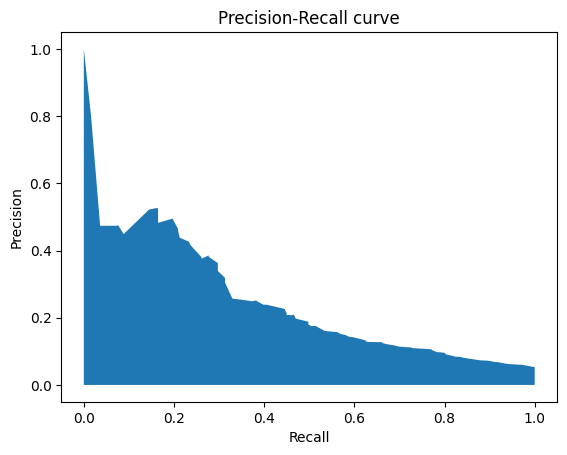

In [46]:
precision, recall, thresholds = precision_recall_curve(y, y_mean)

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve")
plt.show()

In [47]:
y_pred_clf = clf.predict(x)
print(classification_report(y, y_pred_clf))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4735
           1       0.48      0.04      0.07       249

    accuracy                           0.95      4984
   macro avg       0.71      0.52      0.52      4984
weighted avg       0.93      0.95      0.93      4984



## 2.8 - Результаты

In [48]:
# x['actual'] = y
# x['pred'] = y_mean
# x.groupby(['actual'], as_index = False).agg({'pred': 'mean'})

Gini: 0.5642930751517159
-----------------------------------
Результат теста: Зеленый


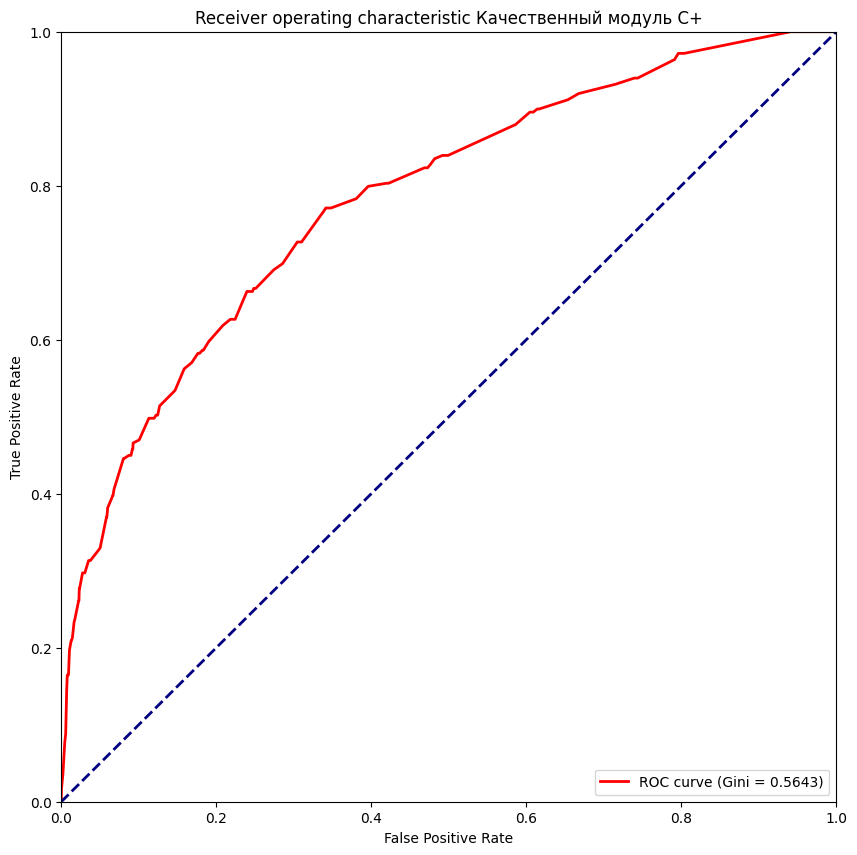

In [49]:
roc(y, y_mean, ' Качественный модуль C+')

In [50]:
df_final = df_prefinal[id_columns+selected_features].copy()
df_final['qualitative_preds'] = y_mean

df_final.groupby(['target'], as_index = False).agg({'qualitative_preds': 'mean'})

,target,qualitative_preds
0,0,0.051954
1,1,0.171216


In [51]:
0.053811 - 0.054566

-0.0007550000000000057

In [52]:
0.082776 - 0.0853993

-0.002623299999999995

Проверка попадания 

In [53]:
target_rate_actual = (df_final[target_col] * df_final[weight_col]).sum() / df_final[weight_col].sum()
target_rate_predicted = df_final['qualitative_preds'].mean()
target_rate_actual, target_rate_predicted

(np.float64(0.055041900550451765), np.float64(0.057912511966033135))

## 2.9 - Сохранение

Сохранение предсказаний

In [54]:
df_final[['rating_id', 'qualitative_preds']].to_parquet(filepath['predictions'])

Сохранение коэффициентов модели

In [55]:
coef_dict = dict(zip(x.columns, coefs,))
coef_dict['intercept'] = model_intercept

for k, v in coef_dict.items():
    coef_dict[k] = float(v)

CONFIG['model_qualitative']['coeffs'] = coef_dict

Сохранение WOE маппинга к категория с учетом объединений после теста монотонности

In [56]:
features_woe_mapping = { f : info for f, info in feature_woe_info.items() if f in selected_features} 

In [57]:
features_woe_mapping = pd.concat(list(features_woe_mapping.values()), ignore_index=True)

features_woe_mapping.to_parquet(filepath['woe_category_map'])

In [58]:
features_woe_mapping.columns

Index(['col_name', 'category', 'count_obs', 'general_distribution', 'goods',
       'distribution_of_good', 'bads', 'distribution_of_bad', 'share_of_bad',
       'woe', 'all_old_categories'],
      dtype='object')

Сохранение информации по метрикам модели

In [59]:
CONFIG['model_qualitative']['gini'] = round(float(gini_mean)*100, 1)
CONFIG['model_qualitative']['target_rate']['actual'] = round(float(target_rate_actual),4)
CONFIG['model_qualitative']['target_rate']['predicted'] = round(float(target_rate_predicted),4)

In [60]:
with open('../CONFIGS.yaml', 'w') as file:
    yaml.dump(CONFIG, file)

In [61]:
features_woe_mapping.query('col_name in @selected_features')[['col_name', 'category', 'count_obs', 'woe', 'share_of_bad', 'all_old_categories']]

,col_name,category,count_obs,woe,share_of_bad,all_old_categories
0,kfx0,3,1601.319739,-52.689828,8.981887,"[3, 4]"
1,kfx0,1,3382.680261,37.241689,3.857891,"[1, 2]"
2,kfx4,2,1656.816450,-30.446278,7.317255,"[2, 3]"
3,kfx4,1,3327.183550,18.899218,4.601349,[1]
4,kfx10,4,602.385631,-70.098599,10.490454,[4]
5,kfx10,3,1782.030192,-31.004802,7.368870,[3]
6,kfx10,1,2599.584177,60.818455,3.070505,"[1, 2]"
7,kfx15,4,4117.474986,-8.986081,5.999344,"[4, 5]"
8,kfx15,1,866.525014,56.814611,3.151362,"[1, 2, 3]"
9,kfx20,9,156.362095,-226.672585,36.086534,[9]


## 2.10 - Оформление эксель

In [62]:
title = 'Качественный модуль Рейтинговой С+'

In [63]:
df_coeffs = pd.DataFrame([coef_dict]).T.reset_index().set_axis(['Признак', 'Коэфф.'], axis=1)
df_coeffs

,Признак,Коэфф.
0,kfx20,-0.009272
1,kfx10,-0.008996
2,kfx0,-0.005899
3,kfx4,-0.005518
4,kfx15,-0.007478
5,intercept,-2.834043


In [64]:
df_metrics = pd.DataFrame([ {  'Процент дефолта (фактический)': round(float(target_rate_actual*100),2)
                             , 'Процент дефолта (прогнозный)' : round(float(target_rate_predicted*100),2)
                             ,  'Gini': round(float(roc_auc_score(y, y_score=y_pred) * 2 - 1)*100, 2)}]).T\
                             .reset_index()\
                             .set_axis(['Метрика', 'Округ. Значение'], axis=1)
df_metrics

,Метрика,Округ. Значение
0,Процент дефолта (фактический),5.50
1,Процент дефолта (прогнозный),5.79
2,Gini,56.45


In [65]:
# df_metrics = pd.DataFrame([ {  'Процент дефолта (фактический)': round(float(df_final['target'].mean()*100),2)
#                              , 'Процент дефолта (прогнозный)' : round(float(df_final['qualitative_preds'].mean()*100),2)
#                              ,  'Gini': round(float(roc_auc_score(y, y_score=y_pred) * 2 - 1)*100, 2)}]).T\
#                              .reset_index()\
#                              .set_axis(['Метрика', 'Округ. Значение'], axis=1)
# df_metrics

In [66]:
df_bins = pd.concat([ f for f in feature_woe_info.values()]).reset_index(drop=True)

In [67]:
selected_features

['kfx20', 'kfx10', 'kfx0', 'kfx4', 'kfx15']

In [68]:
df_bins\
    .query('col_name in @selected_features')\
    [['col_name', 'category', 'woe', 'share_of_bad', 'distribution_of_bad', 'bads', 'count_obs', 'general_distribution']]


,col_name,category,woe,share_of_bad,distribution_of_bad,bads,count_obs,general_distribution
0,kfx0,3.0,-52.689828,8.981887,52.420490,143.828722,1601.319739,32.129208
1,kfx0,1.0,37.241689,3.857891,47.579510,130.500110,3382.680261,67.870792
4,kfx4,2.0,-30.446278,7.317255,44.213856,121.233492,1656.816450,33.242706
5,kfx4,1.0,18.899218,4.601349,55.786144,153.095340,3327.183550,66.757294
21,kfx10,4.0,-70.098599,10.490454,23.091490,63.192988,602.385631,12.086389
22,kfx10,3.0,-31.004802,7.368870,47.788875,131.315495,1782.030192,35.755020
23,kfx10,1.0,60.818455,3.070505,29.119635,79.820349,2599.584177,52.158591
29,kfx15,4.0,-8.986081,5.999344,89.900316,247.021490,4117.474986,82.613864
30,kfx15,1.0,56.814611,3.151362,10.099684,27.307342,866.525014,17.386136
38,kfx20,9.0,-226.672585,36.086534,20.563487,56.425660,156.362095,3.137281


In [69]:
df_bins = pd.concat([ f for f in feature_woe_info.values()]).reset_index(drop=True)
df_bins = df_bins\
    .query('col_name in @selected_features')\
    [['col_name', 'category', 'woe', 'share_of_bad', 'distribution_of_bad', 'bads', 'count_obs', 'general_distribution', 'all_old_categories']]

df_bins.rename(columns= {  'col_name': 'Признак'
                , 'category' : 'Категория (1 - хорошо, N - плохо)'
                , 'woe' : 'Значение WoE'
                , 'share_of_bad' : 'Доля дефолтов'
                , 'distribution_of_bad' : 'Распределение дефолтов'
                , 'bads' : 'К-во дефолтов'
                , 'count_obs' :  'К-во наблюдений'
                , 'general_distribution' :'Общее распределение'
                , 'all_old_categories': 'Включает в себя категории'
                }, inplace=True)

In [70]:
df_meaning_selected = df_meaning.query('feature in @selected_features')
df_meaning_selected.rename(columns={'feature': 'Признак', 'category_meaning' : 'Бизнес-смысл', 'category_code':'Категория'}, inplace=True)

In [71]:
df_coeffs

,Признак,Коэфф.
0,kfx20,-0.009272
1,kfx10,-0.008996
2,kfx0,-0.005899
3,kfx4,-0.005518
4,kfx15,-0.007478
5,intercept,-2.834043


In [72]:
test_results.keys()

dict_keys(['spearman', 'cramers', 'vif', 'gini', 'Wald', 'monotonicity'])

In [73]:
# Инициализируем Excel экспортер
excel = ExcelExporter(filepath['excel'], overwrite=True)

# Создаем листы для каждого датафрейма
sheet_names = [ 'Бизнес_смысл', 'WoE_Биннинг', 'Коэффициенты', 'Метрики', 'Тесты', 'Данные']
excel.create_spreadsheets(sheet_names)


# Лист с бизнес-смыслом
excel.add_title(
    spreadsheet_name='Бизнес_смысл',
    title='Интерпретация Признаков',
    title_type='h1',
    gap=1
)


excel.add_df(
    spreadsheet_name='Бизнес_смысл',
    df=df_meaning_selected,
    title='Бизнес-смысл и логика признаков',
    title_type='h2',
    gap=2
)


# Лист с WoE биннингом
excel.add_title(
    spreadsheet_name='WoE_Биннинг',
    title='WoE Трансформация и Биннинг',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='WoE_Биннинг',
    df=df_bins,
    title='Детализация биннинга по вошедшим признакам',
    title_type='h2',
    gap=2
)

#  Лист с коэффициентами модели
excel.add_title(
    spreadsheet_name='Коэффициенты',
    title='Коэффициенты модели',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='Коэффициенты',
    df=df_coeffs,
    title='Значения коэффициентов, вошедших признаков',
    title_type='h2',
    gap=2
)

#  Лист с метриками модели
excel.add_title(
    spreadsheet_name='Метрики',
    title='Перфоманс',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='Метрики',
    df=df_metrics,
    title='Метрики',
    title_type='h2',
    gap=2
)

#  Лист с тестами 
excel.add_title(
    spreadsheet_name='Тесты',
    title='Тесты',
    title_type='h1',
    gap=1
)

_dfs_tests = list(test_results.values())
_dfs_tests_titles = (pd.Series(test_results.keys())
                     .map({'spearman'     : 'Коэффициент ранговой корреляции Спирмена'
                         , 'cramers'      : 'Коэффициент сопряженности Крамера'
                         , 'vif'          : 'Коэффициент инфляции дисперсии'
                         , 'gini'         : 'Джини признака'
                         , 'monotonicity' : 'Тест на монотонность признака'
                         , 'Wald'         : 'Тест Вальда'})
                     .tolist())

# Добавление всех датафреймов вертикально (друг под другом)
excel.add_dfs(
    spreadsheet_name="Тесты",
    dfs=_dfs_tests,
    titles=_dfs_tests_titles,
    side_by_side=False,  # друг под другом
    vgap=2  # отступ между датафреймами
)

# 4. Лист с выборкой
excel.add_title(
    spreadsheet_name='Данные',
    title='Данные',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='Данные',
    df=df_final,
    title='Получившийся датасет',
    title_type='h2',
    gap=2
)

excel.save()

print(f"✅ Эксель-файл создан в {filepath['excel']}")

Файл '../results/Качественная модель С+ 2025.xlsx' был удален и будет создан заново.
✅ Эксель-файл создан в ../results/Качественная модель С+ 2025.xlsx
